/home/osajima/miniforge3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


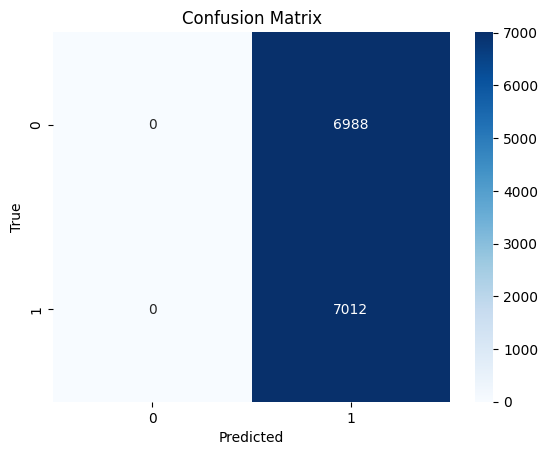

(0.5008571428571429, 0.667428136303065)

In [5]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
from fttransformer import FTTransformer
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# データの読み込みと前処理
data = pd.read_csv("/home/osajima/ドキュメント/program/Transformer_Study/fttransformer_pytorch/cardio_train.csv", sep=';')

# 'id' を削除
data = data.drop(columns=["id"])

# 特徴量とラベルに分割
X = data.drop(columns=["cardio"])
y = data["cardio"]

# カテゴリカルと連続値の分離（仮に3つをカテゴリカルとみなす）
categorical_cols = ["gender", "cholesterol", "gluc"]
continuous_cols = [col for col in X.columns if col not in categorical_cols]

# ラベルエンコーディング
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# スケーリング（連続値）
scaler = StandardScaler()
X[continuous_cols] = scaler.fit_transform(X[continuous_cols])

# 学習・テストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PyTorch Dataset 定義
class CardioDataset(Dataset):
    def __init__(self, X, y):
        self.X_categ = torch.tensor(X[categorical_cols].values, dtype=torch.long)
        self.X_cont = torch.tensor(X[continuous_cols].values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_categ[idx], self.X_cont[idx], self.y[idx]

# データローダー
train_dataset = CardioDataset(X_train, y_train)
test_dataset = CardioDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512)

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルの定義
model = FTTransformer(
    categories=[X[col].nunique() for col in categorical_cols],
    num_continuous=len(continuous_cols),
    dim=32,
    depth=4,
    heads=4,
    ff_dropout=0.1,
    attn_dropout=0.1
).to(device)

# 損失関数と最適化手法
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 学習ループ（簡易版）
for epoch in range(5):
    model.train()
    for x_cat, x_cont, labels in train_loader:
        x_cat, x_cont, labels = x_cat.to(device), x_cont.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(x_cat, x_cont)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# 評価
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for x_cat, x_cont, labels in test_loader:
        x_cat, x_cont = x_cat.to(device), x_cont.to(device)
        outputs = model(x_cat, x_cont)
        preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
        all_preds.extend(preds.flatten())
        all_labels.extend(labels.numpy())

# スコア計算
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

acc, f1
